In [1]:
import sys, os
sys.path.append('..')
sys.path.append('.')

import yaml

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

#import wandb
#resume = False
#wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
#wandb_id = '3cyfilm7'
#models_dir = './wandb_models'
# wandb.init(project="asmr-impact", resume=resume, id=wandb_id)
# wandb_id = wandb.run.id
#save_dir = os.path.join('./wandb', wandb_id)
#conf = wandb.config
#print(wandb_id)

3cyfilm7


In [2]:
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 0.5
offset_secs = 1.17

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-0.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav


In [3]:
model = ddsp.training.models.get_model()

Z time steps: 126


In [4]:
model.restore(save_dir)

INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


In [5]:
# Loading and processing audio
MAX_WAV_VALUE = 32768.0
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-173-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
# audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-198-of-365" # Ceramic plate example
audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-240-of-365" # wooden box example
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-72-of-365' # Glassbowl example
#audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio.shape)

# waveglow style
print("decoded audio before: ", decoded_audio)
# decoded_audio = decoded_audio / MAX_WAV_VALUE
print("decoded audio after: ", decoded_audio)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
IPython.display.Audio(data=decoded_audio, rate=int(audio_sample_rate))

audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (441344, 1)
decoded audio before:  tf.Tensor(
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [-0.00097656]
 [-0.00097656]
 [-0.00100708]], shape=(441344, 1), dtype=float32)
decoded audio after:  tf.Tensor(
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [-0.00097656]
 [-0.00097656]
 [-0.00100708]], shape=(441344, 1), dtype=float32)
(1, 22050)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 22050), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 22050)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[7.2482002e-01 5.5014765e-01 1.5214631e-01 ... 3.2031294e-05
   5.8504709e-05 7.5072050e-05]
  [1.0515135e-01 7.2708714e-01 3.2849315e-01 ... 1.2942875e-04
   1.1864299e-04 6.0349703e-06]
  [1.3720359e+00 1.1986808e+00 4.1865402e-01 ... 2.2497118e-04
   1.7461958e-04 2.4318695e-05]
  ...
  [3.9232802e-01 2.5527124e+00 4.0834827e+00 ... 7.3741479e-03
   7.4572568e-03 7.5486749e-03]
  [9.4823921e-01 9.4174320e-01 9.0463108e-01 ... 4.5341286e-03
   4.5378800e-03 4.5450032e-03]
  [1.6823267e-03 1.6807973e-03 1.6762177e-03 ... 7.9485420e-05
   7.9484198e-05 7.9490361e-05]]], shape=(1, 87, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.00000000e+00 4.39968556e-01 1.10179074e-01 ... 1.80681027e-03
   1.73533452e-03 2.02159653e-03]
  [0.00000

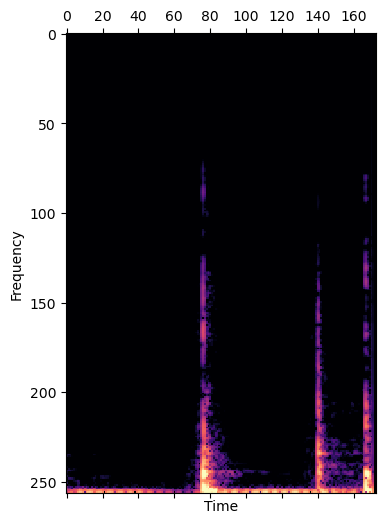

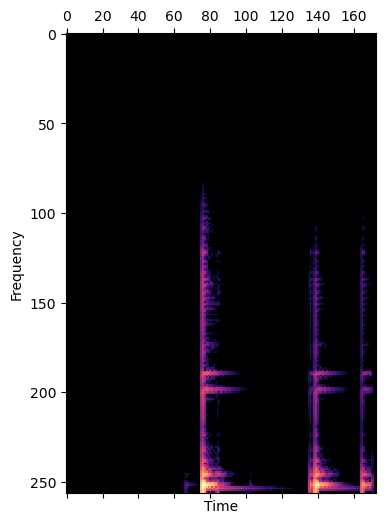

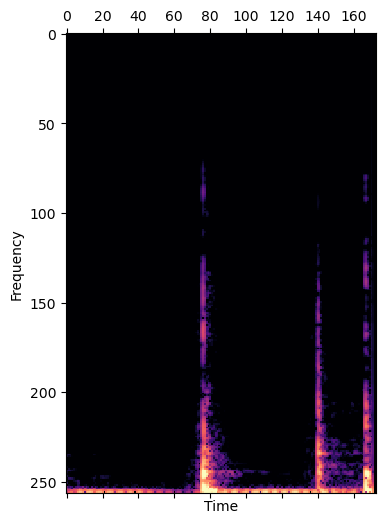

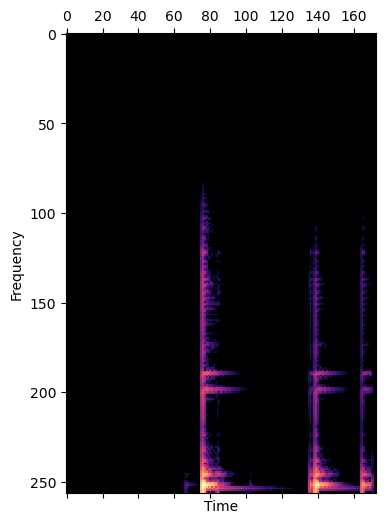

In [6]:
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [7]:
for k in prediction:
    print(k)
print(prediction['reverb_decay'])
print(prediction['reverb_gain'])

inputs
audio
material_id
video_id
z
material_embedding
magnitudes
stdevs
taus
gains
frequencies
dampings
tau_multiplier
acceleration_scalar
reverb_gain
reverb_decay
noise_magnitudes
impact
modal_fir
convolve
filtered_noise
add1
acceleration_multiply
add2
reverb
resample
out
audio_synth
tf.Tensor([[0.01559967]], shape=(1, 1), dtype=float32)
tf.Tensor(
[[ 0.00234329 -0.0036285   0.02966794  0.02578888 -0.09611432  0.10113382
  -0.01739896 -0.07547379  0.18080805  0.00281618  0.09012411  0.02933635
  -0.00706805  0.04616449  0.25710884  0.1464489   0.47209966 -0.00558962
   0.0145811  -0.00495632 -0.02088506  0.05109269  0.01438165  0.01321384
  -0.04677949 -0.01578008 -0.0060592   0.07381374  0.02992893  0.03537934
   0.43692726 -0.01033593]], shape=(1, 32), dtype=float32)


In [8]:
print(prediction['impact']['signal'])

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 88200), dtype=float32)


In [2]:
# Try all of the above with mel spectrogram as input instead of audio
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 1 # This determines how the time dims of output in seconds. Set to 10 for full orig audio
offset_secs = 1.17

latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-1.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav


In [3]:
model = ddsp.training.models.get_model()

Z time steps: 252


In [4]:
model.restore(save_dir)

INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


In [5]:
from IPython.display import display
import soundfile as sf
# Loading and processing audio
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365.wav'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-100-of-365'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_mel.npy')

# sf.write(os.path.join(save_dir, audio_title+'_original_audio.wav'),
#                        orig_audio[offset_samples:(offset_samples + test_samples)], 44100)

print("mel spectrogram vanilla: ", audio)
# regnet prediction/output
# audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy") # From regnet output

print("orig audio shape: ", orig_audio.shape)
print("mel spec shape: ", audio.shape)
audio_sample_rate = 44100
# Force it to 87 time dim to be 0.5 seconds
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# 1 second is 172 in mel spec time dimensions
audio = audio[:, int(offset_secs * 172):int(offset_secs*172 + example_secs*172)]
# if example_secs == 0.5:
#     audio = audio[:, :87]
# elif example_secs == 5:
#     audio = audio[:, 861:]
# elif example_secs == 1:
#     audio = audio[:, :172]
    
audio = np.transpose(audio)
tf_audio = tf.convert_to_tensor(audio)
decoded_mel_spec = tf.expand_dims(tf_audio, axis=0)

# For original audio
orig_audio = tf.convert_to_tensor(orig_audio)
#decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[:test_samples]), axis=0)
#decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio), axis=0)
print("decoded orig audio shape: ", decoded_orig_audio.shape)

# Save the shortened audio
# scipy.io.wavfile.write(os.path.join(save_dir, audio_title+'_original_audio.wav'), audio_sample_rate,
#                        tf.make_ndarray(tf.make_tensor_proto(orig_audio[offset_samples:(offset_samples + test_samples)])))
#synth_wav = tf.audio.encode_wav(prediction['audio_synth'][:1, :], sample_rate=audio_sample_rate)

# Compare to load from wav
compare_decoded_audio, compare_audio_sample_rate = tf.audio.decode_wav(compare_audio, desired_channels=1)
compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[:test_samples]), axis=0)
#compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio), axis=0)
print("compare decoded orig audio (from wav): ", compare_decoded_orig_audio.shape)

print(decoded_mel_spec.shape)
test_input_new = tf.data.Dataset.from_tensor_slices({'audio':decoded_mel_spec, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input_new)

print("decoded orig audio loaded with numpy")
print(decoded_orig_audio)
#plt.plot(decoded_orig_audio)
display(IPython.display.Audio(data=decoded_orig_audio, rate=int(audio_sample_rate)))

print("decoded orig audio loaded with tensorflow")
print(compare_decoded_orig_audio)
display(IPython.display.Audio(data=compare_decoded_orig_audio, rate=int(audio_sample_rate)))
#plt.show()

mel spectrogram vanilla:  [[-11.512925  -11.512925   -8.285768  ...  -3.525048   -4.7328687
   -4.6909904]
 [-11.512925  -11.512925   -8.09303   ...  -4.5592575  -5.677803
   -5.84312  ]
 [-11.512925  -11.512925   -7.88805   ...  -6.1050863  -6.1220856
   -7.4842157]
 ...
 [-11.512925  -11.512925  -11.512925  ...  -9.183427   -9.469207
  -11.142398 ]
 [-11.512925  -11.512925  -11.512925  ...  -9.485366   -9.960242
  -11.512925 ]
 [-11.512925  -11.512925  -11.512925  ...  -9.99114   -10.4671135
  -11.512925 ]]
orig audio shape:  (441000,)
mel spec shape:  (80, 1720)
decoded orig audio shape:  (1, 44100)
compare decoded orig audio (from wav):  (1, 44100)
(1, 172, 80)
input to the model:  <BatchDataset shapes: {audio: (None, 172, 80), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>
decoded orig audio loaded with numpy
tf.Tensor([[ 14.  16.  16. ...  17.  14. -35.]], shape=(1, 44100), dtype=float32)


decoded orig audio loaded with tensorflow
tf.Tensor(
[[ 0.00030518  0.00033569  0.00039673 ... -0.00494385 -0.00708008
  -0.00311279]], shape=(1, 44100), dtype=float32)


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 172, 80)
passing in the log mel spectrogram as is...
Mel spec MFCC logmel shape:  (1, 172, 80)
log mel values:  tf.Tensor(
[[[ -5.718073   -7.1247444  -7.257015  ... -11.512925  -11.512925
   -11.512925 ]
  [ -5.5580697  -6.7165427  -7.385764  ... -11.512925  -11.512925
   -11.512925 ]
  [ -5.814795   -7.8523927  -7.073192  ... -11.512925  -11.512925
   -11.512925 ]
  ...
  [ -3.441331   -4.5709724  -5.667815  ...  -8.08199    -8.987253
    -9.990481 ]
  [ -4.2160544  -5.3923445  -7.500162  ...  -7.7475142  -9.624763
   -10.372516 ]
  [ -5.457428   -6.639557   -7.138772  ...  -7.35868    -9.687081
   -10.855912 ]]], shape=(1, 172, 80), dtype=float32)
mel spec mfcc shape:  (1, 172, 80)
Input to processor group:  dict_keys(['audio', 'material_id', 'video_id', 'z', 'material_embedding', 'magnitudes', 'stdevs', 'taus', 'gains', 'frequencies', 'dampings', 'tau_multiplier',

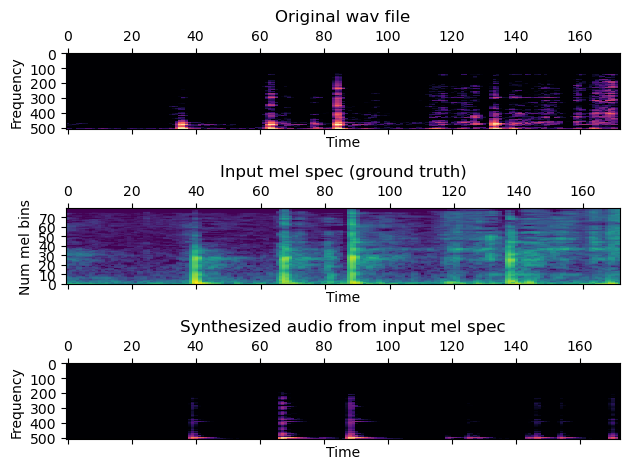

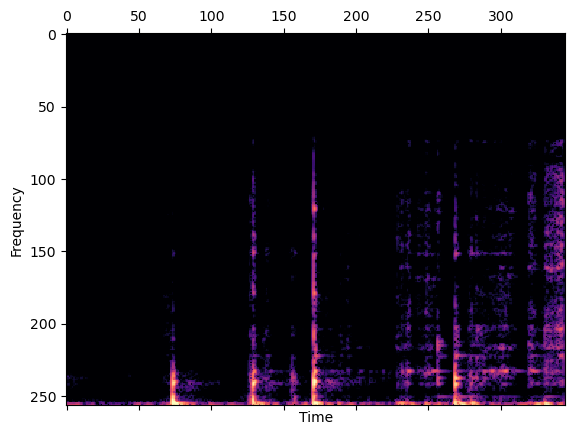

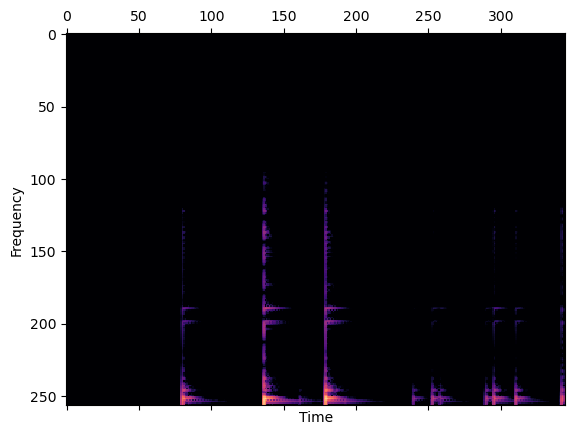

In [6]:
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
#import librosa
#print(librosa.__version__)
MAX_WAV_VALUE = 32768.0
prediction = model(next(iter(test_input_new)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)

# Saving the audio
# synth_wav = tf.audio.encode_wav(prediction['audio_synth'][:1, :], sample_rate=audio_sample_rate)
# with open(os.path.join(save_dir, audio_title+'_gt_mel_spec_synth.wav'), 'wb') as f:
#     f.write(synth_wav)
# proto_tensor = tf.make_tensor_proto(a)
# np_array_synth = tf.make_ndarray(synth_wav)
# scipy.io.wavfile.write(os.path.join(save_dir, audio_title+'_gt_mel_spec_synth.wav'),
#                         audio_sample_rate, synth_wav)
# sf.write(os.path.join(save_dir, audio_title+'_gt_mel_spec_synth.wav'),
#                        tf.make_ndarray(prediction['audio_synth'][:1, :]), int(audio_sample_rate))
# scipy.io.wavfile.write(filename, fs, np.array(32767 * audio[i, :] / np.max(np.abs(audio))).astype(np.int16))

# plt.figure(figsize=(13, 10))
#ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][0,:,:], size=512)

# ddsp.colab.colab_utils.specplot_mel_spec(prediction['audio'][0,:,:], size=512)
fig, axs = plt.subplots(3)
title1 = 'Original wav file'
axs[0].set_title(title1)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=1024, axs=axs[0]) #orig wav file

axs[1].matshow(tf.transpose(prediction['audio'][0,:,:]), aspect='auto', origin='lower') # input mel spec
axs[1].set_title("Input mel spec (ground truth)")
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Num mel bins')

title2 = 'Synthesized audio from input mel spec'
axs[2].set_title(title2)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=1024, axs=axs[2]) # synthesized audio pred
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

# ddsp.colab.colab_utils.specplot(prediction['audio'][0,:, :train_sample_rate*2], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()

IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [7]:
for k in prediction:
    print(k)
print(prediction['reverb_decay'])
print(prediction['reverb_gain'])

inputs
audio
material_id
video_id
z
material_embedding
magnitudes
stdevs
taus
gains
frequencies
dampings
tau_multiplier
acceleration_scalar
reverb_gain
reverb_decay
noise_magnitudes
impact
modal_fir
convolve
filtered_noise
add1
acceleration_multiply
add2
reverb
resample
out
audio_synth
tf.Tensor([[0.01559967]], shape=(1, 1), dtype=float32)
tf.Tensor(
[[ 0.00234329 -0.0036285   0.02966794  0.02578888 -0.09611432  0.10113382
  -0.01739896 -0.07547379  0.18080805  0.00281618  0.09012411  0.02933635
  -0.00706805  0.04616449  0.25710884  0.1464489   0.47209966 -0.00558962
   0.0145811  -0.00495632 -0.02088506  0.05109269  0.01438165  0.01321384
  -0.04677949 -0.01578008 -0.0060592   0.07381374  0.02992893  0.03537934
   0.43692726 -0.01033593]], shape=(1, 32), dtype=float32)


In [8]:
print(prediction['impact']['signal'])

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 88200), dtype=float32)


In [9]:
# Compare against regnet's output mel spectrogram
print("Using Regnet's prediction log mel spectrogram")
from IPython.display import display
example_secs = 1 # This determines how the time dims of output in seconds. Set to 10 for full orig audio
offset_secs = 1.17
# Loading and processing audio
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365.wav'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-273-of-365'
audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_mel.npy')

# regnet prediction/output
audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy") # For regnet output

print("orig audio shape: ", orig_audio.shape)
print("mel spec shape: ", audio.shape)
audio_sample_rate = 44100
# Force it to 87 time dim to be 0.5 seconds
audio = audio[:, int(offset_secs * 172):int(offset_secs*172 + example_secs*172)]
#audio = audio[:, :87]
# audio = audio[:, :172]
audio = np.transpose(audio)
tf_audio = tf.convert_to_tensor(audio)
decoded_mel_spec = tf.expand_dims(tf_audio, axis=0)

# For original audio
orig_audio = tf.convert_to_tensor(orig_audio)
#decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
# decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[:test_samples]), axis=0)
print("decoded orig audio shape: ", decoded_orig_audio.shape)

# Compare to load from wav
compare_decoded_audio, compare_audio_sample_rate = tf.audio.decode_wav(compare_audio, desired_channels=1)
# compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[:test_samples]), axis=0)
compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)

# Add the processed mel spec to input
print(decoded_mel_spec.shape)
test_input_new = tf.data.Dataset.from_tensor_slices({'audio':decoded_mel_spec, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input_new)

print("decoded orig audio loaded with numpy")
print(decoded_orig_audio)
display(IPython.display.Audio(data=decoded_orig_audio, rate=int(audio_sample_rate)))

print("decoded orig audio loaded with tensorflow")
print(compare_decoded_orig_audio)
display(IPython.display.Audio(data=compare_decoded_orig_audio, rate=int(audio_sample_rate)))

Using Regnet's prediction log mel spectrogram
orig audio shape:  (441000,)
mel spec shape:  (80, 1720)
decoded orig audio shape:  (1, 44100)
(1, 172, 80)
input to the model:  <BatchDataset shapes: {audio: (None, 172, 80), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>
decoded orig audio loaded with numpy
tf.Tensor([[ 14.  16.  16. ...  17.  14. -35.]], shape=(1, 44100), dtype=float32)


decoded orig audio loaded with tensorflow
tf.Tensor(
[[ 0.00030518  0.00033569  0.00039673 ... -0.00494385 -0.00708008
  -0.00311279]], shape=(1, 44100), dtype=float32)


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 172, 80)
passing in the log mel spectrogram as is...
Mel spec MFCC logmel shape:  (1, 172, 80)
log mel values:  tf.Tensor(
[[[ -4.6108117  -4.546528   -4.5341315 ... -11.361057  -11.307845
   -11.317619 ]
  [ -4.749879   -4.9377627  -5.3815784 ... -11.200466  -11.068035
   -11.19234  ]
  [ -5.0424986  -5.5909925  -6.360691  ... -11.267506  -11.269601
   -11.229385 ]
  ...
  [ -5.614657   -6.237666   -6.809435  ... -11.490736  -11.49812
   -11.675611 ]
  [ -5.7513795  -6.294419   -6.8338203 ... -11.458768  -11.53133
   -11.668654 ]
  [ -5.519898   -5.971703   -6.4587865 ... -11.127449  -11.212626
   -11.439467 ]]], shape=(1, 172, 80), dtype=float32)
mel spec mfcc shape:  (1, 172, 80)
Input to processor group:  dict_keys(['audio', 'material_id', 'video_id', 'z', 'material_embedding', 'magnitudes', 'stdevs', 'taus', 'gains', 'frequencies', 'dampings', 'tau_multiplier', '

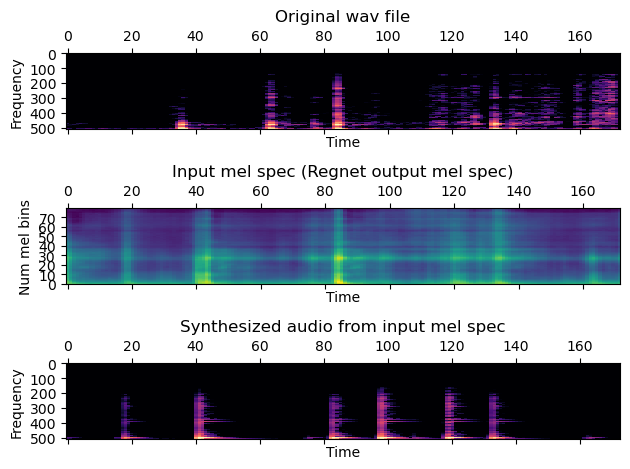

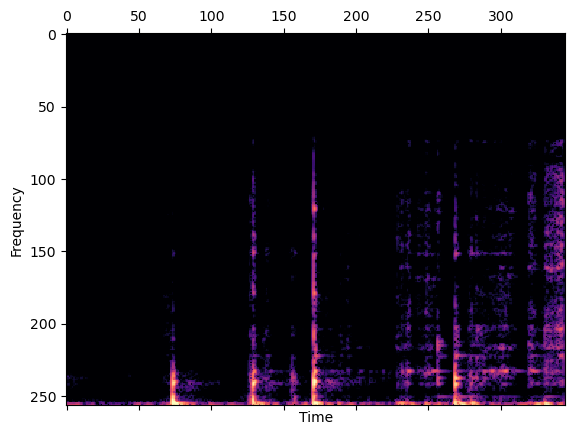

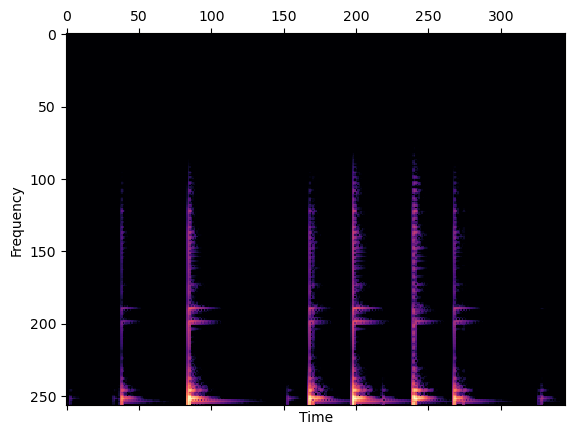

In [10]:
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
prediction = model(next(iter(test_input_new)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)

# Saving the audio
# synth_wav = tf.audio.encode_wav(prediction['audio_synth'][:1, :], sample_rate=audio_sample_rate)
# with open(os.path.join(save_dir, audio_title+'_regnet_mel_spec_synth.wav'), 'wb') as f:
#     f.write(synth_wav)

#ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)

fig, axs = plt.subplots(3)
title1 = 'Original wav file'
axs[0].set_title(title1)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=1024, axs=axs[0]) #orig wav file

axs[1].matshow(tf.transpose(prediction['audio'][0,:,:]), aspect='auto', origin='lower') # input mel spec
axs[1].set_title("Input mel spec (Regnet output mel spec)")
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Num mel bins')

title2 = 'Synthesized audio from input mel spec'
axs[2].set_title(title2)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=1024, axs=axs[2]) # synthesized audio pred
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

# ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=1024) #orig wav file
# plt.show()
# plt.imshow(tf.transpose(prediction['audio'][0,:,:]), aspect='auto', origin='lower') # input mel spec
# ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=1024) # synthesized audio pred

#ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [2]:
fig_width = 6
fig_height = 4
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    if len(audio.shape) == 2:
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    print(np.max(logmag))
    f, t, Zxx = scipy.signal.stft(audio, train_sample_rate, nperseg=size, noverlap=int(0.75*size))
    # logmag = spectral_ops.compute_logmel(core.tf_float32(audio), lo_hz=8.0, bins=80, fft_size=size)
    # logmag = spectral_ops.compute_mfcc(core.tf_float32(audio), mfcc_bins=40, fft_size=size)
    if rotate:
        # logmag = np.rot90(np.log(np.abs(Zxx)))
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(test_samples) / train_sample_rate
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, example_secs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    xtick_locs = (xtick_nums / example_secs * logmag.shape[1]).astype(np.int32)
    xtick_nums = xtick_locs / logmag.shape[1] * example_secs
    plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # plt.yticks([])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-0.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav


INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


Z time steps: 126
audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (440320, 1)
decoded audio before:  tf.Tensor(
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.00015259]
 [0.00015259]
 [0.00018311]], shape=(440320, 1), dtype=float32)
decoded audio after:  tf.Tensor(
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.00015259]
 [0.00015259]
 [0.00018311]], shape=(440320, 1), dtype=float32)
(1, 22050)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 22050), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 22050)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[9.58617106e-02 7.01715946e-02 1.86996117e-01 ... 1.12778725e-04
   1.29621912e-04 2.66805291e-05]
  [8.56391639e-02 1.12216264e-01 3.86508435e-01 ... 2.06169672e-04
   1.43476092e-04 9.64142382e-05]
  [1.69967398e-01 3.42026174e-01 5.26982486e-01 ... 9.40174505e-05
   1.05920772e-04 1.70022249e-05]
  ...
  [4.25386727e-02 4.27091755e-02 3.45742702e-02 ... 8.92268581e-05
   7.71276973e-05 8.64956528e-05]
  [1.15015181e-02 1.10203316e-02 9.66648292e-03 ... 3.51355629e-05
   2.16058015e-05 1.34715810e-05]
  [1.91986692e-06 1.95386065e-06 2.05196466e-06 ... 4.03235987e-07
   4.01578518e-07 4.01032594e-07]]], shape=(1, 87, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.0000000e+00 5.6118201e-02 1.4053394e-02 ... 1.0173458e-01
   4.1685279

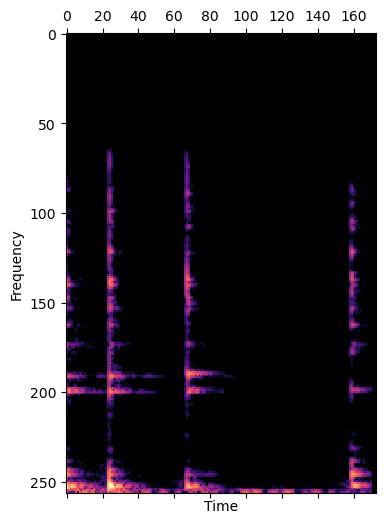

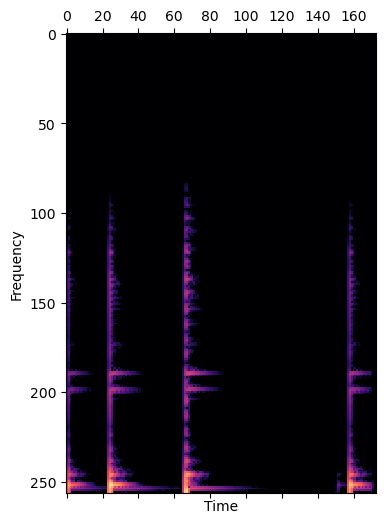

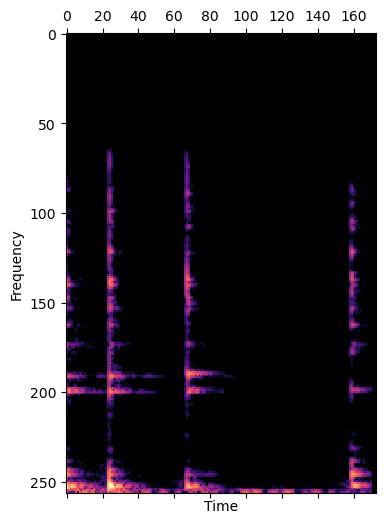

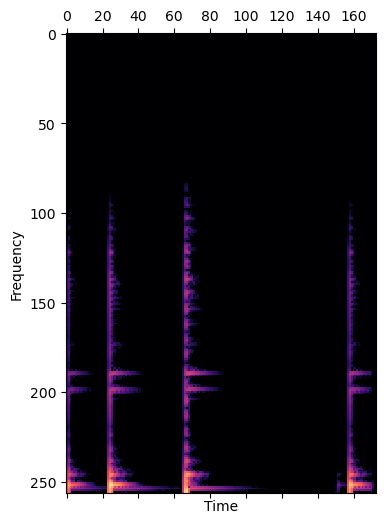

In [3]:
from IPython.display import display
# Full pipeline
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 0.5
offset_secs = 1.17

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

model = ddsp.training.models.get_model()

model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-173-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
#audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-198-of-365" # Ceramic plate example
audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-72-of-365' # Glassbowl example
#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-90-of-365'   # Glassbowl example 2
#audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-840-of-1165' # glassbowl example 3
#audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio.shape)

# waveglow style
print("decoded audio before: ", decoded_audio)
# decoded_audio = decoded_audio / MAX_WAV_VALUE
print("decoded audio after: ", decoded_audio)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(audio_sample_rate)))

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

1.1974921
(257,)
(197, 173)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


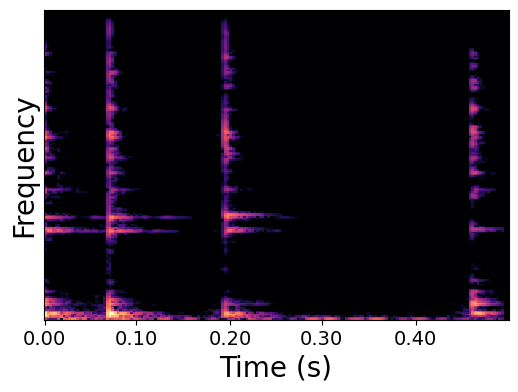

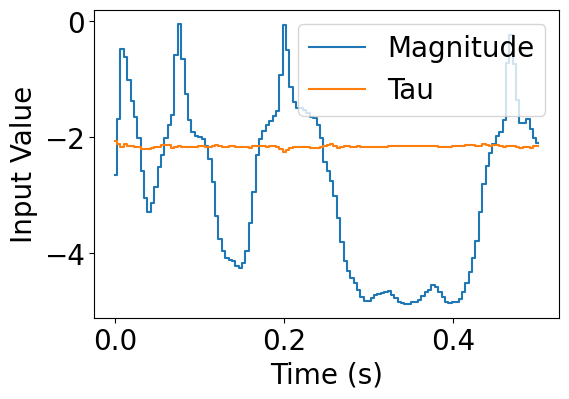

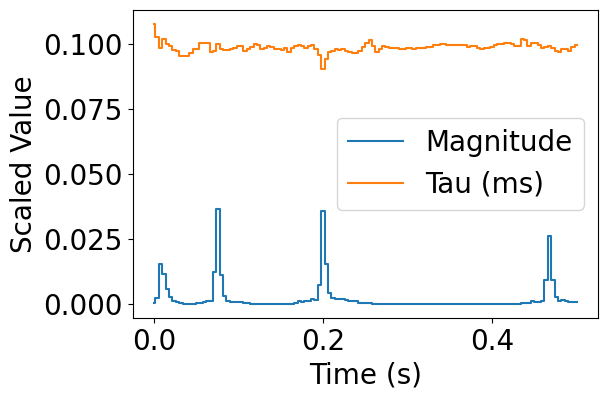

n_frames: 127 and n_intervals: 126
n_frames: 127 and n_intervals: 126


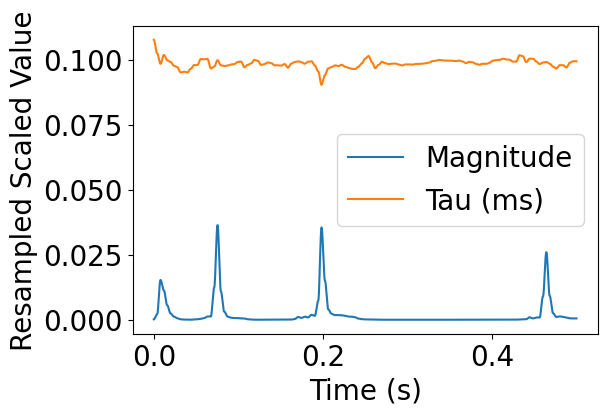

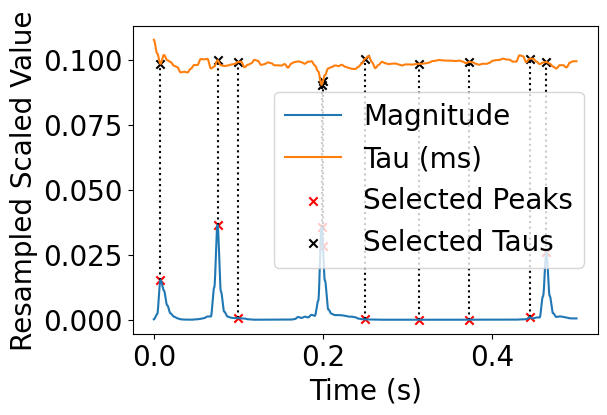

augmented indices: [[[[  250   350   450]
   [ 3225  3325  3425]
   [ 4310  4410  4510]
   [ 8650  8750  8850]
   [ 8720  8820  8920]
   [10925 11025 11125]
   [13725 13825 13925]
   [16350 16450 16550]
   [19500 19600 19700]
   [20375 20475 20575]]]]
b: 1, w: 1, h: 22050, c: 1


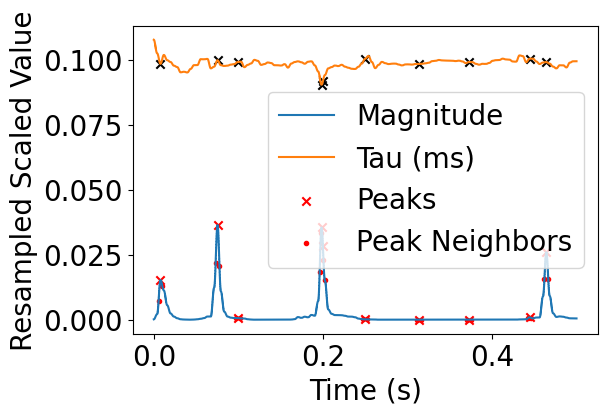

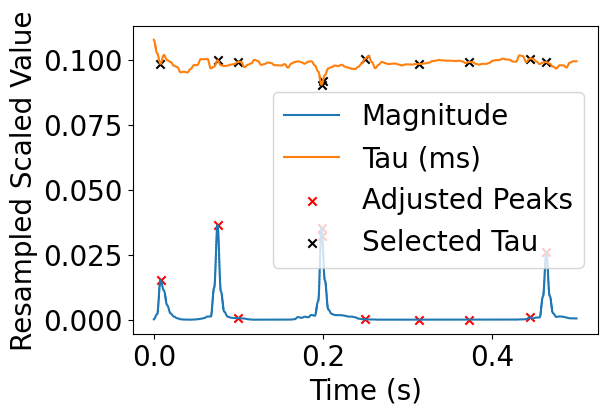

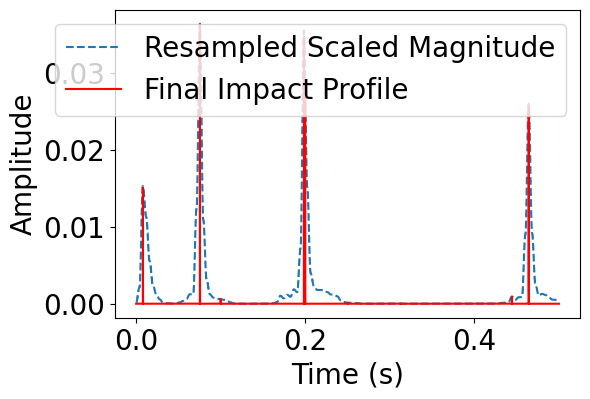

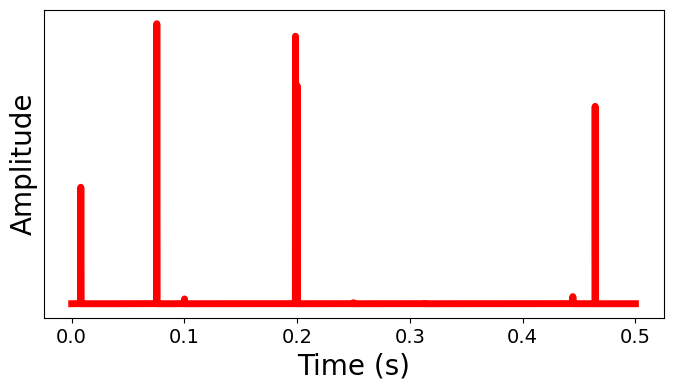

0.5844369
(257,)
(197, 173)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


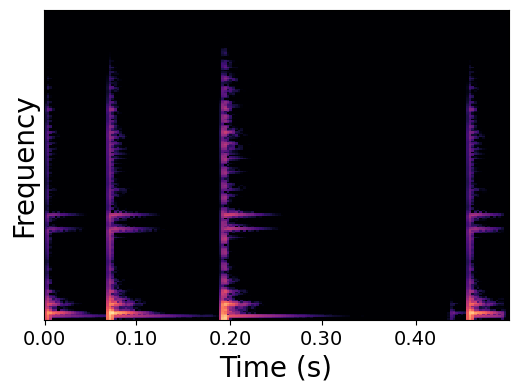

In [4]:
no_axis = True
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 20
plt.rcParams['font.size'] = font_size

save_title = audio_title.split('.')[0]

#output_dir = '/home/samuel/Downloads/impact_profile_noaxis'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/impact_profile_noaxis'
os.makedirs(output_dir, exist_ok=True)
plot_spec(prediction['audio'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
    plt.ylabel('Frequency')
    
fig.savefig(os.path.join(output_dir, save_title+'_original_spec.png'), bbox_inches='tight')
plt.show()

logit_length = np.squeeze(prediction['magnitudes']).shape[0]
t_logit = np.linspace(0, test_samples/train_sample_rate, logit_length)
plt.plot(t_logit, np.squeeze(prediction['magnitudes']), drawstyle='steps-mid')
plt.plot(t_logit, np.squeeze(prediction['taus']), drawstyle='steps-mid')
plt.legend(('Magnitude', 'Tau'))
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_logits.png'), bbox_inches='tight')
plt.show()

plt.plot(t_logit, np.squeeze(prediction['impact']['controls']['magnitudes']), drawstyle='steps-mid')
plt.plot(t_logit, 1000 * np.squeeze(prediction['impact']['controls']['taus']), drawstyle='steps-mid')
plt.legend(('Magnitude', 'Tau (ms)'))
plt.xlabel('Time (s)')
plt.ylabel('Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_scaled_logits.png'), bbox_inches='tight')
plt.show()

t = np.linspace(0, test_samples/train_sample_rate, test_samples)
magnitude_envelopes = ddsp.core.resample(prediction['impact']['controls']['magnitudes'], test_samples,
                                        method='window')
taus = ddsp.core.resample(prediction['impact']['controls']['taus'], test_samples,
                                        method='window')
plt.plot(t, np.squeeze(magnitude_envelopes))
plt.plot(t, 1000 * np.squeeze(taus))
plt.legend(('Magnitude', 'Tau (ms)'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_resampled_logits.png'), bbox_inches='tight')
plt.show()

window_size = int(train_sample_rate / 20)
magnitude_envelopes = tf.expand_dims(magnitude_envelopes, axis=1)
weight_distance = 100
vals, inds = tf.nn.max_pool_with_argmax(magnitude_envelopes, window_size, window_size, 'SAME')
plt.plot(t, np.squeeze(magnitude_envelopes))
plt.plot(t, 1000 * np.squeeze(taus))
plt.scatter(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.vlines(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], colors='black', linestyles='dotted')
plt.legend(('Magnitude', 'Tau (ms)', 'Selected Peaks', 'Selected Taus'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.savefig(os.path.join(output_dir, save_title+'_peak_selection.png'), bbox_inches='tight')
fig.set_size_inches(fig_width, fig_height)
plt.show()

# Use a weighted average of magnitude to select peak time so that things can shift around
augmented_inds = tf.concat([inds - weight_distance, inds, inds + weight_distance], axis=-1)
print(f"augmented indices: {augmented_inds}")
b,w,h,c = magnitude_envelopes.get_shape().as_list()
print(f"b: {b}, w: {w}, h: {h}, c: {c}")
mags_pooled = tf.gather(tf.reshape(magnitude_envelopes, shape=[b*w*h*c]), augmented_inds)
plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid')
plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
plt.scatter(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds-weight_distance)], np.squeeze(magnitude_envelopes)[np.squeeze(inds-weight_distance)], marker='.', c='red')
plt.scatter(t[np.squeeze(inds+weight_distance)], np.squeeze(magnitude_envelopes)[np.squeeze(inds+weight_distance)], marker='.', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.legend(('Magnitude', 'Tau (ms)', 'Peaks', 'Peak Neighbors'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_peak_adjustment.png'), bbox_inches='tight')
plt.show()

weighted_inds = tf.reduce_sum(tf.cast(augmented_inds, dtype=tf.float32) * mags_pooled, axis=-1) / tf.reduce_sum(mags_pooled, axis=-1)
peak_times = tf.cast(weighted_inds / train_sample_rate, dtype=tf.float32)
plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid')
plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
plt.scatter(peak_times, np.squeeze(magnitude_envelopes)[np.squeeze(weighted_inds).astype(np.int32)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.legend(('Magnitude', 'Tau (ms)', 'Adjusted Peaks', 'Selected Tau'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_adjusted_peaks.png'), bbox_inches='tight')
plt.show()

plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid', linestyle='dashed')
# plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
# plt.scatter(peak_times, np.squeeze(magnitude_envelopes)[np.squeeze(weighted_inds).astype(np.int32)], marker='x', c='red')
# plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(('Resampled Scaled Magnitude','Final Impact Profile'))
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_impact_signal.png'), bbox_inches='tight')
plt.show()

t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red', linewidth=5)

impact_profile = np.squeeze(prediction['impact']['signal'])
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
   
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_impact_signal_only.png'), bbox_inches='tight')
plt.show()

plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_synth_spec.png'), bbox_inches='tight')
plt.show()

(176400,)
ir values:  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15 1.8402892e-15
 1.8896143e-15]


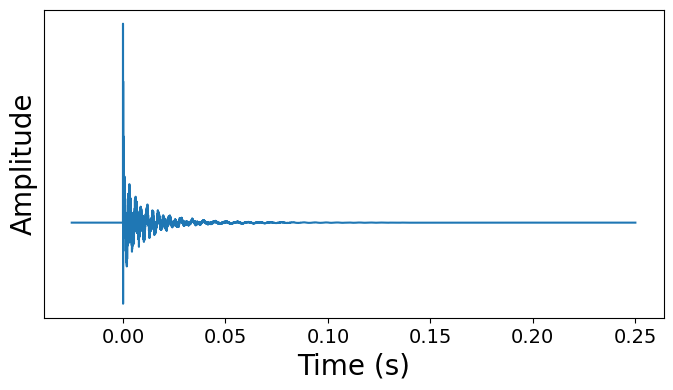

In [5]:
#output_dir = '/home/samuel/Downloads/modal_fir'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/modal_fir'
os.makedirs(output_dir, exist_ok=True)
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir = np.squeeze(prediction['modal_fir']['signal']) # modal response
print(ir.shape)
print("ir values: ", ir)
ir = ir[begin_offset:cutoff]
impulse_profile = ir
t2 = (np.arange(0, ir.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_ir.png'), bbox_inches='tight')
plt.show()

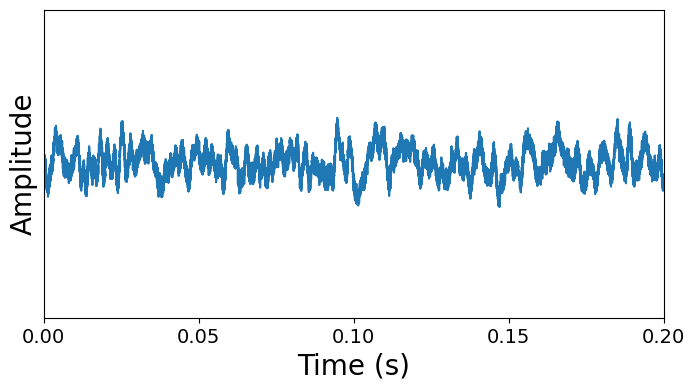

In [6]:
#output_dir = '/home/samuel/Downloads/filtered_noise'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/filtered_noise'
os.makedirs(output_dir, exist_ok=True)

noise = np.squeeze(prediction['filtered_noise']['signal'])
t2 = np.arange(0, 2 * train_sample_rate * example_secs) / (2 * train_sample_rate)
plt.plot(t2, noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim((-0.0002, 0.0002))
plt.xlim((0, 0.2))
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_ir.png'), bbox_inches='tight')
plt.show()

(48882,)


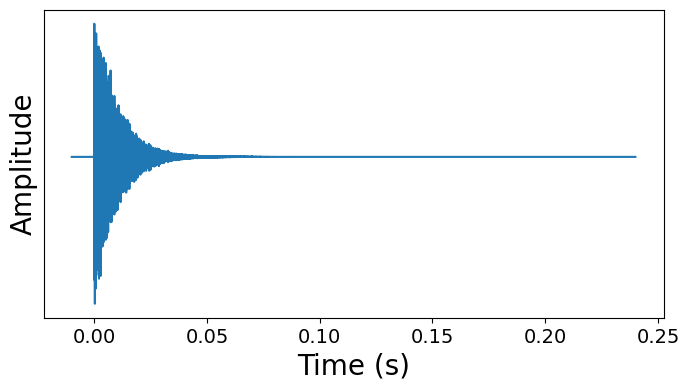

In [7]:
#output_dir = '/home/samuel/Downloads/modal_fir'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/modal_fir'
begin_offset = int(train_sample_rate * 0.02)
cutoff = int(train_sample_rate * 0.5)

ir = np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir']))) # env response from reverb
print(ir.shape)
ir = ir[:cutoff]
rev = ir
t2 = (np.arange(0, ir.shape[0])  - begin_offset) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_room_ir.png'), bbox_inches='tight')
plt.show()

0.5844369
(257,)
(197, 173)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


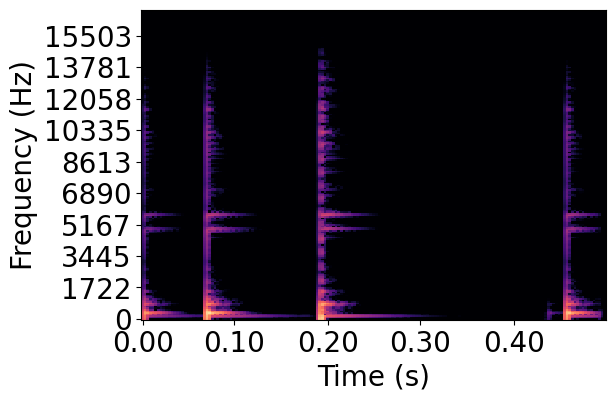

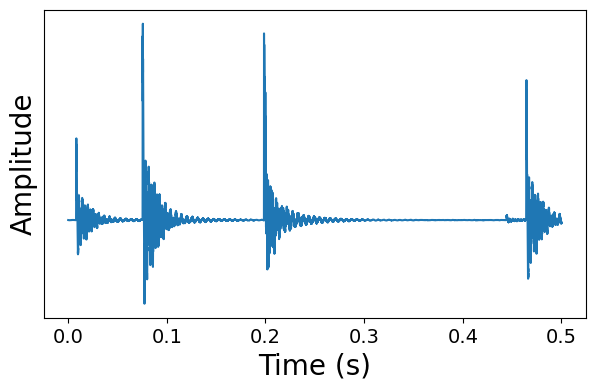

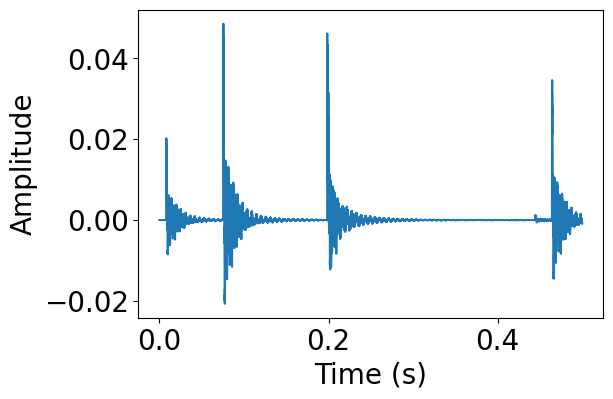

In [8]:
#output_dir = '/home/samuel/Downloads/final_audio'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/final_audio'
os.makedirs(output_dir, exist_ok=True)

plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
fig.savefig(os.path.join(output_dir, save_title+'_synth_spec.png'), bbox_inches='tight')
plt.show()
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+1, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_waveform.png'), bbox_inches='tight')
plt.show()
plt.rcParams.update({
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),
})
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_waveform_translucent.png'), bbox_inches='tight')
plt.show()

In [9]:
# print(prediction['modal_fir']['controls']['frequencies'])
# if False:
modal_model = np.zeros((len(np.squeeze(prediction['modal_fir']['controls']['frequencies'])), 3), dtype=np.float32)
modal_model[:, 0] = np.squeeze(prediction['modal_fir']['controls']['frequencies'])
modal_model[:, 1] = np.squeeze(prediction['modal_fir']['controls']['gains'])
modal_model[:, 2] = np.squeeze(prediction['modal_fir']['controls']['dampings'])
np.save(os.path.join(output_dir, save_title+'_modal_model.npy'), modal_model)

In [10]:
# Use this method!!!!!
def generate_audio(predictions, modal_fir, reverb, impulse_profile, gains, frequencies, dampings, modal_response,
                   noise, acceleration_scale, revc):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR --> modal response (object material sound)
    #irc = modal_fir.get_controls(gains, frequencies, dampings)
    irc_scratch = modal_fir.get_controls(predictions['gains'], predictions['frequencies'], predictions['dampings'])
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    print("ir: ", ir)
    print("model's output modal response: ", modal_response)
    print("ir_scratch: ", ir_scratch)
    # Convolve together for modal vibration sounds
    audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    print("convolved shape: ", audio.shape)
    
    # Generate and add time constant noise
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate), 'linear')
    return audio

In [12]:
# Initialize modules
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_samples), sample_rate=int(sample_factor * audio_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate), n_samples=int(sample_factor * train_samples), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

# print(f"Glass example 1, before get_controls(). gains: {prediction['gains']}, \
#       freq: {prediction['frequencies']}, \
#       dampings: {prediction['dampings']}")

print(f"Glass example 1, after get_controls(). gains: {prediction['modal_fir']['controls']['gains'].shape}, \
      freq: {prediction['modal_fir']['controls']['frequencies'].shape}, \
      dampings: {prediction['modal_fir']['controls']['dampings'].shape}")

# Play it
# def generate_audio(modal_fir, impact, reverb, impulse_profile, ir, aud_info, noise, reverb_env_resp)
acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))
print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")
# audio_final = generate_audio(reverb, impulse_profile, ir, noise, acceleration_scale, revc)
# audio_final = generate_audio(modal_fir, impact, reverb, prediction['impact']['controls']['magnitudes'],
#                              prediction['stdevs'], prediction['impact']['controls']['taus'],
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              noise, rev,
#                              prediction['reverb_gain'], prediction['reverb_decay'],
#                              accel_scalar)
# gains, frequencies, dampings in prediction['modal_fir']['controls'] have already gone through get_controls() scaling functions
audio_final = generate_audio(prediction, modal_fir, reverb, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc)
print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
IPython.display.Audio(data=audio_final, rate=int(audio_sample_rate))

Glass example 1, before get_controls(). gains: [[-1.3081588e-02 -3.1090459e-02 -6.5691806e-02 -1.8689549e-02
  -1.3118864e+00  1.2793970e+00 -4.0091675e-02 -9.6995926e-01
  -5.6176233e-01 -9.7295439e-01 -1.5993069e+00  4.6466312e-01
  -5.8962584e-01  1.8001744e+00 -2.2311478e+00 -9.4369829e-02
  -1.2441630e+00 -1.0390431e+00 -1.2490994e+00 -4.7431421e-01
  -3.6911321e-01 -1.3324111e+00 -1.2403673e+00 -7.8090835e-01
  -1.7562370e+00 -1.2730887e+00 -1.5177450e+00  3.2088869e+00
  -1.5093333e+00  1.8010646e+00  1.8377204e+00 -8.2877380e-01
  -7.5412095e-01  1.6274515e+00  1.9974493e+00  1.5497421e-01
  -1.7539006e+00 -1.4254780e-01  3.9617780e-01  2.3273300e-02
   2.1027648e+00  9.2362159e-01  2.2767344e+00  3.1235960e-01
   1.7987548e-01 -2.0106570e-01  6.7116350e-01  4.3700403e-03
  -4.5079818e-01  1.1497836e+00 -1.0227090e+00  2.3630459e-03
   3.2765320e-01  9.0522647e-02  3.2251576e-01  2.6529865e+00
  -7.1349460e-01 -2.2090109e-01  4.7277126e-01 -1.1376530e+00
   7.4280262e-01 -5.661

Size of frequency envelope:  (1, 88200, 256)
size of amplitude envelop:  (1, 88200, 256)
ir:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15
  1.8402892e-15 1.8896143e-15]], shape=(1, 176400), dtype=float32)
model's output modal response:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15
  1.8402892e-15 1.8896143e-15]], shape=(1, 176400), dtype=float32)
ir_scratch:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15
  1.8402892e-15 1.8896143e-15]], shape=(1, 176400), dtype=float32)
audio_frames shape:  (1, 1, 44100)
n_audio_frames: 1 and n_ir_frames: 1
convolved shape:  (1, 44100)
after adding noise:  (1, 44100)
after acceleration sound:  (1, 44100)
audio_frames shape:  (1, 1, 44100)
n_audio_frames: 1 and n_ir_frames: 1
after reverb:  (1, 44100)
audio sample rate:  tf.Tensor(44100, shape=(), dtype=int32)
final audio shape: (1, 44100) compared to audio_synth shape: (1, 22050)


In [ ]:
# def generate_audio(modal_fir, impact, reverb, mags, stdevs, taus,
#                    gains, frequencies, dampings,
#                    noise, reverb_env_resp,
#                    reverb_gains, reverb_decay, acceleration_scale):
def generate_audio(reverb, impulse_profile, ir, noise, acceleration_scale, revc):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse
    # magnitude_envelopes, taus, prediction['stdevs']
    #impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
    #impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR
    #irc = modal_fir.get_controls(gains, frequencies, dampings)
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    print("ir shape: ", ir.shape)
    # Convolve together for modal vibration sounds
    audio = ddsp.core.fft_convolve(impulse_profile, ir)
    print("convolved shape: ", audio.shape)
#     audio = ddsp.core.fft_convolve(impulse_profile, impact_profile)
    
    # Generate and add time constant noise
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, audio_sample_rate, 'linear')
    return audio


INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-0.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav
Z time steps: 126
audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (440320, 1)
decoded audio before:  tf.Tensor(
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [-0.0005188 ]
 [-0.00057983]
 [-0.0005188 ]], shape=(440320, 1), dtype=float32)
decoded audio after:  tf.Tensor(
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [-0.0005188 ]
 [-0.00057983]
 [-0.0005188 ]], shape=(440320, 1), dtype=float32)
(1, 22050)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 22050), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 22050)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[2.3842163e+00 2.8389063e+00 9.2953485e-01 ... 5.0985189e-05
   1.0364581e-04 8.0466270e-05]
  [3.8027008e+00 4.2689619e+00 1.3061495e+00 ... 1.2619214e-04
   1.4627000e-04 1.1181831e-04]
  [7.7477112e+00 6.7158513e+00 3.6165802e+00 ... 1.3235646e-04
   1.2272804e-04 1.7547607e-04]
  ...
  [1.7370958e+00 1.4723233e+00 8.8562638e-01 ... 4.8697698e-03
   4.9020224e-03 4.9353838e-03]
  [5.0157714e-01 4.7616246e-01 4.0851969e-01 ... 2.9790055e-03
   2.9829112e-03 2.9871464e-03]
  [1.0887489e-03 1.0879046e-03 1.0853764e-03 ... 5.2721989e-05
   5.2718664e-05 5.2721647e-05]]], shape=(1, 87, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.0000000e+00 2.2703533e+00 5.6855297e-01 ... 3.9832689e-02
   4.5348346e-02 4.6303328e-02]
  [0.0000000e+00

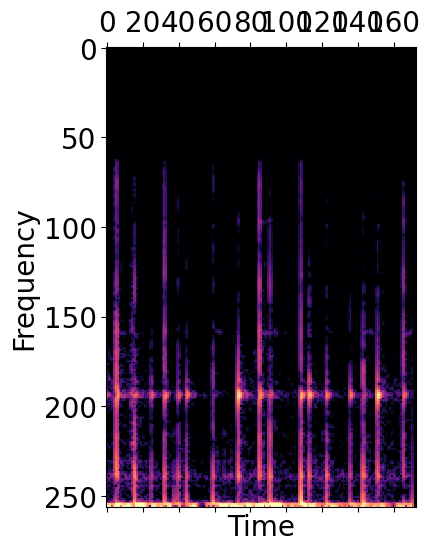

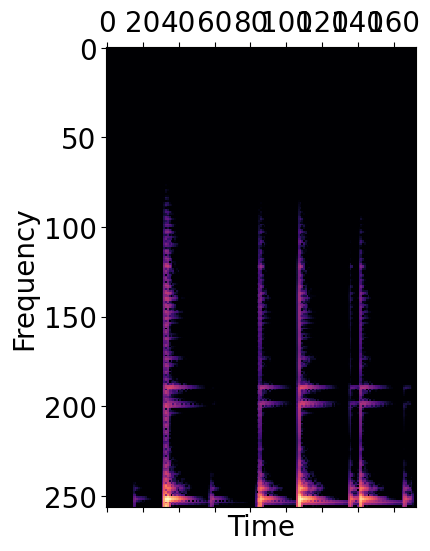

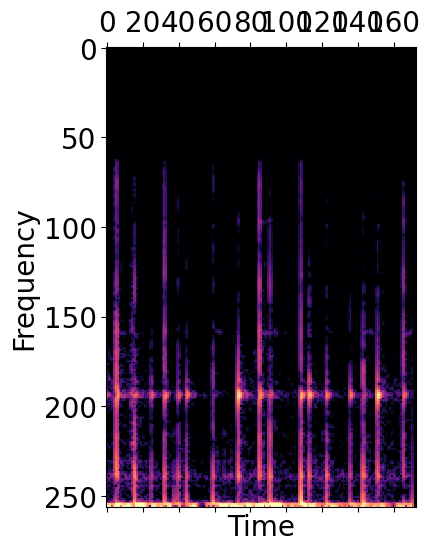

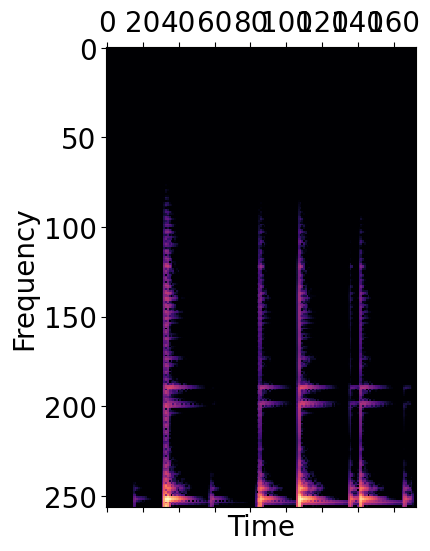

In [13]:
# Full pipeline for another modal response
from IPython.display import display
# Full pipeline
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 0.5
offset_secs = 1.17

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

model = ddsp.training.models.get_model()

model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-173-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
#audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-198-of-365" # Ceramic plate example
#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-72-of-365' # Glassbowl example
#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-90-of-365'   # Glassbowl example 2
audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-840-of-1165' # glassbowl example 3
#audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio.shape)

# waveglow style
print("decoded audio before: ", decoded_audio)
# decoded_audio = decoded_audio / MAX_WAV_VALUE
print("decoded audio after: ", decoded_audio)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(audio_sample_rate)))

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction_ceramic = model(next(iter(test_input)), training=False)
print("pred audio shape: ", prediction_ceramic['audio'].shape)
print("pred audio synth shape: ", prediction_ceramic['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction_ceramic['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction_ceramic['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction_ceramic['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction_ceramic['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction_ceramic['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

(176400,)
ir values:  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15 1.8402892e-15
 1.8896143e-15]


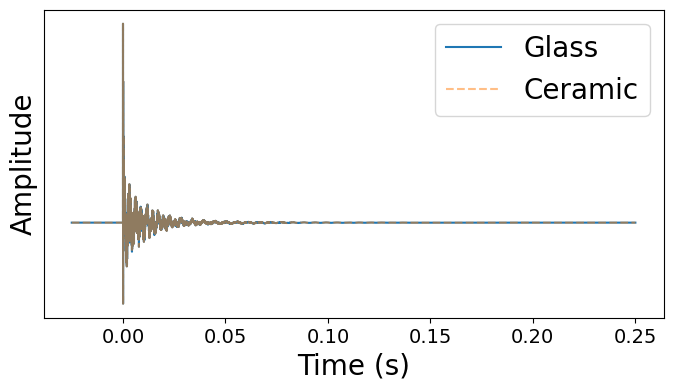

In [14]:
#output_dir = '/home/samuel/Downloads/modal_fir'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/modal_fir'
os.makedirs(output_dir, exist_ok=True)
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir = np.squeeze(prediction['modal_fir']['signal']) # modal response
print(ir.shape)
print("ir values: ", ir)
ir = ir[begin_offset:cutoff]
impulse_profile = ir
t2 = (np.arange(0, ir.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir)
ir_ceramic = np.squeeze(prediction_ceramic['modal_fir']['signal'])
ir_ceramic = ir_ceramic[begin_offset:cutoff]
plt.plot(t2, ir_ceramic, linestyle="dashed", alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(('Glass', 'Ceramic'))
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
# fig.savefig(os.path.join(output_dir, save_title+'_ir.png'), bbox_inches='tight')
plt.show()

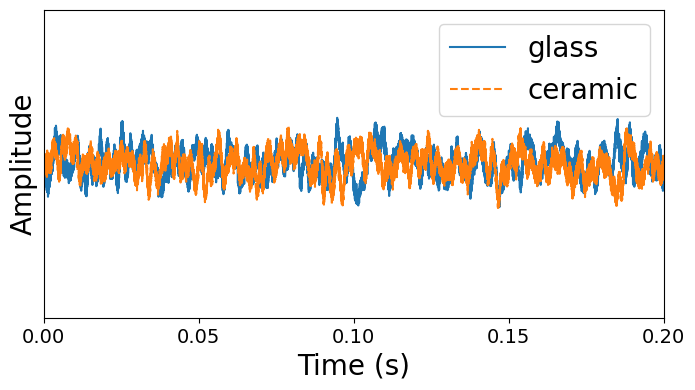

In [15]:
#output_dir = '/home/samuel/Downloads/filtered_noise'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/filtered_noise'
os.makedirs(output_dir, exist_ok=True)

noise = np.squeeze(prediction['filtered_noise']['signal'])
noise_ceramic = np.squeeze(prediction_ceramic['filtered_noise']['signal'])
t2 = np.arange(0, 2 * train_sample_rate * example_secs) / (2 * train_sample_rate)
plt.plot(t2, noise)
plt.plot(t2, noise_ceramic, linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(('glass', 'ceramic'))
plt.ylim((-0.0002, 0.0002))
plt.xlim((0, 0.2))
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
# fig.savefig(os.path.join(output_dir, save_title+'_ir.png'), bbox_inches='tight')
plt.show()

(48882,)


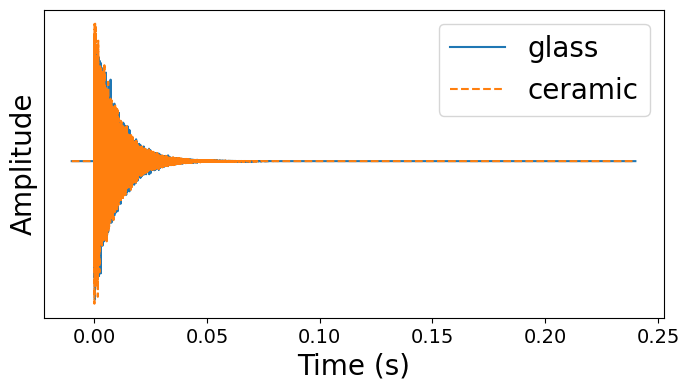

In [16]:
#output_dir = '/home/samuel/Downloads/modal_fir'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/modal_fir'
begin_offset = int(train_sample_rate * 0.02)
cutoff = int(train_sample_rate * 0.5)

ir = np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir']))) # env response from reverb
print(ir.shape)
ir = ir[:cutoff]
rev = ir
ir_ceramic = np.concatenate((np.zeros(begin_offset), np.squeeze(prediction_ceramic['reverb']['controls']['ir'])))
ir_ceramic = ir_ceramic[:cutoff]
t2 = (np.arange(0, ir.shape[0])  - begin_offset) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.plot(t2, ir_ceramic, linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(('glass', 'ceramic'))
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_room_ir.png'), bbox_inches='tight')
plt.show()

In [17]:
print(prediction['material_embedding'].shape)

(1, 8)


In [26]:
# Initialize modules
# sample_factor = 2
# modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_samples), sample_rate=int(sample_factor * audio_sample_rate),
#                             initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
# impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate), n_samples=int(sample_factor * train_samples), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
# reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

# print(f"Glass example 2, before get_controls(). gains: {prediction_ceramic['gains']}, \
#       freq: {prediction_ceramic['frequencies']}, \
#       dampings: {prediction_ceramic['dampings']}")

# print(f"Glass example 2, after get_controls(). gains: {prediction_ceramic['modal_fir']['controls']['gains'].shape}, \
#       freq: {prediction_ceramic['modal_fir']['controls']['frequencies'].shape}, \
#       dampings: {prediction_ceramic['modal_fir']['controls']['dampings'].shape}")

check = tf.math.equal(prediction['gains'], prediction_ceramic['gains'])
check2 = tf.math.equal(prediction['frequencies'], prediction_ceramic['frequencies'])
check3 = tf.math.equal(prediction['dampings'], prediction_ceramic['dampings'])
print(tf.math.reduce_all(check))
print(tf.math.reduce_all(check2))
print(tf.math.reduce_all(check3))
check11 = tf.math.equal(prediction_ceramic['modal_fir']['controls']['gains'], prediction['modal_fir']['controls']['gains'])
print(tf.math.reduce_all(check11))
check12 = tf.math.equal(prediction_ceramic['modal_fir']['controls']['frequencies'], prediction['modal_fir']['controls']['frequencies'])
print(tf.math.reduce_all(check12))
check13 = tf.math.equal(prediction_ceramic['modal_fir']['controls']['dampings'], prediction['modal_fir']['controls']['dampings'])
print(tf.math.reduce_all(check13))

sanity = tf.math.equal(prediction['filtered_noise']['signal'], prediction_ceramic['filtered_noise']['signal'])
print("should be false: ", tf.math.reduce_any(sanity))
sanity2 = tf.math.equal(prediction['gains'], prediction_ceramic['modal_fir']['controls']['gains'])
print("should also be false: ", tf.math.reduce_any(sanity2))

# Play it
# def generate_audio(modal_fir, impact, reverb, impulse_profile, ir, aud_info, noise, reverb_env_resp)
acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction_ceramic['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))
print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")
# audio_final = generate_audio(reverb, impulse_profile, ir, noise, acceleration_scale, revc)
# audio_final = generate_audio(modal_fir, impact, reverb, prediction['impact']['controls']['magnitudes'],
#                              prediction['stdevs'], prediction['impact']['controls']['taus'],
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              noise, rev,
#                              prediction['reverb_gain'], prediction['reverb_decay'],
#                              accel_scalar)
# gains, frequencies, dampings in prediction['modal_fir']['controls'] have already gone through get_controls() scaling functions
audio_final = generate_audio(prediction_ceramic, modal_fir, reverb, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc)
print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction_ceramic['audio_synth'].shape}")
IPython.display.Audio(data=audio_final, rate=int(audio_sample_rate))

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
should be false:  tf.Tensor(False, shape=(), dtype=bool)
should also be false:  tf.Tensor(False, shape=(), dtype=bool)
input shapes! impulse_profile: (1, 44100), ir: (1, 176400), noise: (1, 44100), revc: (1, 48000)
impulse profile shape:  (1, 44100)
Size of frequency envelope:  (1, 1, 256)
size of amplitude envelop:  (1, 256)
Size of frequency envelope:  (1, 88200, 256)
size of amplitude envelop:  (1, 88200, 256)
Size of frequency envelope:  (1, 88200, 256)
size of amplitude envelop:  (1, 88200, 256)
ir:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15
  1.8402892e-15 1.8896143e-15]], shape=(1, 176400), dtype=float32)
model's output modal response:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7906179e-15
  1.8402892e-15 

In [23]:
acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction_ceramic['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))
print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")
audio_final = generate_audio(reverb, impulse_profile, ir, noise, acceleration_scale, revc)
# audio_final = generate_audio(modal_fir, impact, reverb, prediction['impact']['controls']['magnitudes'],
#                              prediction['stdevs'], prediction['impact']['controls']['taus'],
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              noise, rev,
#                              prediction['reverb_gain'], prediction['reverb_decay'],
#                              accel_scalar)
print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
IPython.display.Audio(data=audio_final, rate=int(audio_sample_rate))

input shapes! impulse_profile: (1, 44100), ir: (1, 176400), noise: (1, 44100), revc: (1, 48000)
impulse profile shape:  (1, 44100)
ir shape:  (1, 176400)
audio_frames shape:  (1, 1, 44100)
n_audio_frames: 1 and n_ir_frames: 1
convolved shape:  (1, 44100)
after adding noise:  (1, 44100)
after acceleration sound:  (1, 44100)
audio_frames shape:  (1, 1, 44100)
n_audio_frames: 1 and n_ir_frames: 1
after reverb:  (1, 44100)
audio sample rate:  tf.Tensor(44100, shape=(), dtype=int32)
final audio shape: (1, 44100) compared to audio_synth shape: (1, 22050)


In [10]:
# Verify the final audio by generating it based on the frequencies, gains, and dampings
# Generate impulse responses
# Initialize modules, with internal sampling rate 2x the original recording sample rate
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_samples), sample_rate=int(sample_factor * audio_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate), n_samples=int(sample_factor * train_samples), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)
#modal_fir = ddsp.synths.ModalFIR(n_samples=int(fs*sample_factor/1.0), sample_rate=int(fs*sample_factor),
#                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
#impact = ddsp.synths.Impact(sample_rate=int(fs*sample_factor), n_samples=int(clip.shape[0]*sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
#reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

# magnitude_envelopes = ddsp.core.resample(prediction['impact']['controls']['magnitudes'], test_samples,
#                                         method='window')
# taus = ddsp.core.resample(prediction['impact']['controls']['taus'], test_samples,
#                                         method='window')
# print("impact control keys: ", prediction['impact']['controls'].keys())
# stdevs = ddsp.core.resample(prediction['stdevs'], test_samples, method='window')
# impc = impact.get_controls(prediction['impact']['controls']['magnitudes'], prediction['stdevs'],
#                            prediction['impact']['controls']['taus'], 0)
# impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
# print("impulse profile shape: ", impulse_profile.shape)

# # Generate modal FIR
# gains = aud_info[:,0]
# frequencies = aud_info[:,1]
# dampings = aud_info[:,2]
# print(f"saved shape for gains: {gains.shape}, freq: {frequencies.shape}, dampings: {dampings.shape}")
# print(f"orig shape for gains: {prediction['modal_fir']['controls']['gains'].shape}, \
#       freq: {prediction['modal_fir']['controls']['frequencies'].shape}, damp: {prediction['modal_fir']['controls']['dampings'].shape}")
# irc = modal_fir.get_controls(prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'], prediction['modal_fir']['controls']['dampings'])
# ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])
# print("ir shape: ", ir.shape)
print(f"gains: {prediction['modal_fir']['controls']['gains'].shape}, \
      freq: {prediction['modal_fir']['controls']['frequencies'].shape}, \
      dampings: {prediction['modal_fir']['controls']['dampings'].shape}")

# Play it
# def generate_audio(modal_fir, impact, reverb, impulse_profile, ir, aud_info, noise, reverb_env_resp)
acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))
print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")
# audio_final = generate_audio(reverb, impulse_profile, ir, noise, acceleration_scale, revc)
# audio_final = generate_audio(modal_fir, impact, reverb, prediction['impact']['controls']['magnitudes'],
#                              prediction['stdevs'], prediction['impact']['controls']['taus'],
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              noise, rev,
#                              prediction['reverb_gain'], prediction['reverb_decay'],
#                              accel_scalar)
print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
IPython.display.Audio(data=audio_final, rate=int(audio_sample_rate))

gains: (1, 1, 256),       freq: (1, 1, 256),       dampings: (1, 256)
input shapes! impulse_profile: (1, 44100), ir: (1, 176400), noise: (1, 44100), revc: (1, 48000)


NameError: name 'audio_final' is not defined

INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-0.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav
Z time steps: 126
audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (441344, 1)
decoded audio before:  tf.Tensor(
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [-0.00097656]
 [-0.00097656]
 [-0.00100708]], shape=(441344, 1), dtype=float32)
decoded audio after:  tf.Tensor(
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [-0.00097656]
 [-0.00097656]
 [-0.00100708]], shape=(441344, 1), dtype=float32)
(1, 22050)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 22050), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 22050)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[7.2482002e-01 5.5014765e-01 1.5214631e-01 ... 3.2031294e-05
   5.8504709e-05 7.5072050e-05]
  [1.0515135e-01 7.2708714e-01 3.2849315e-01 ... 1.2942875e-04
   1.1864299e-04 6.0349703e-06]
  [1.3720359e+00 1.1986808e+00 4.1865402e-01 ... 2.2497118e-04
   1.7461958e-04 2.4318695e-05]
  ...
  [3.9232802e-01 2.5527124e+00 4.0834827e+00 ... 7.3741479e-03
   7.4572568e-03 7.5486749e-03]
  [9.4823921e-01 9.4174320e-01 9.0463108e-01 ... 4.5341286e-03
   4.5378800e-03 4.5450032e-03]
  [1.6823267e-03 1.6807973e-03 1.6762177e-03 ... 7.9485420e-05
   7.9484198e-05 7.9490361e-05]]], shape=(1, 87, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.00000000e+00 4.39968556e-01 1.10179074e-01 ... 1.80681027e-03
   1.73533452e-03 2.02159653e-03]
  [0.00000

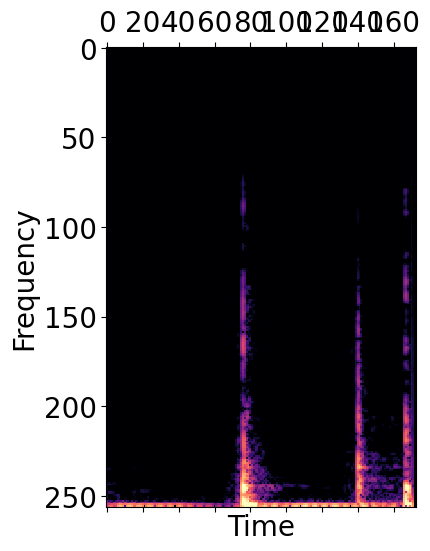

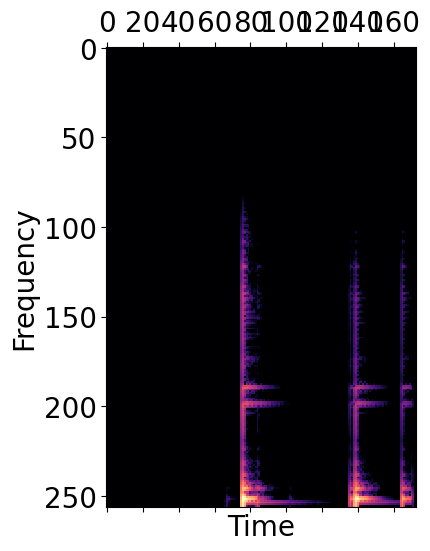

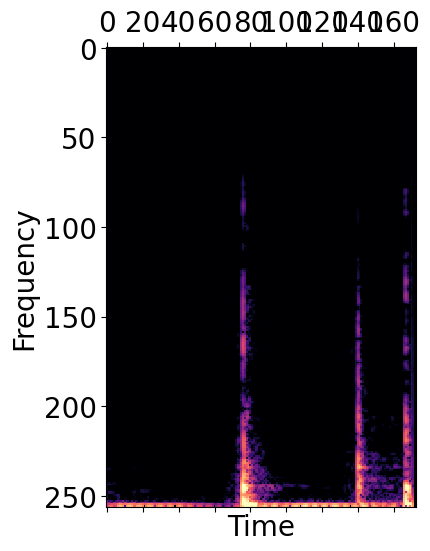

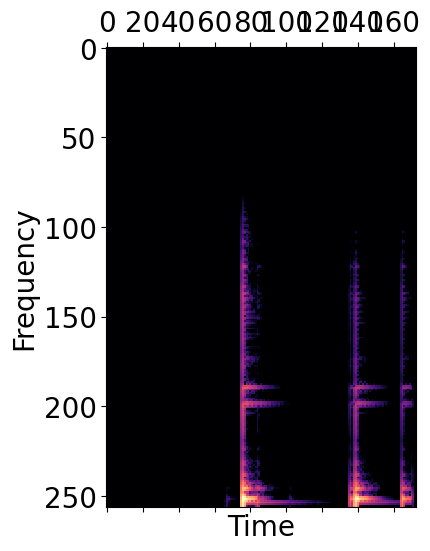

In [31]:
# Full pipeline for another modal response
from IPython.display import display
# Full pipeline
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 0.5
offset_secs = 1.17

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

model = ddsp.training.models.get_model()

model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-173-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-240-of-365" # wooden box example
# audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-198-of-365" # Ceramic plate example
#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-72-of-365' # Glassbowl example
#audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio.shape)

# waveglow style
print("decoded audio before: ", decoded_audio)
# decoded_audio = decoded_audio / MAX_WAV_VALUE
print("decoded audio after: ", decoded_audio)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(audio_sample_rate)))

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction_box = model(next(iter(test_input)), training=False)
print("pred audio shape: ", prediction_box['audio'].shape)
print("pred audio synth shape: ", prediction_box['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction_box['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction_box['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction_box['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction_box['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction_box['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [35]:
print(tf.math.reduce_all(tf.math.equal(prediction_box['gains'], prediction['gains'])))
print(tf.math.reduce_all(tf.math.equal(prediction_box['frequencies'], prediction['frequencies'])))
print(tf.math.reduce_all(tf.math.equal(prediction_box['dampings'], prediction['dampings'])))
print(tf.math.reduce_any(tf.math.equal(prediction_box['modal_fir']['signal'], prediction['modal_fir']['signal'])))

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)


In [14]:
# def generate_audio(modal_fir, impact, reverb, mags, stdevs, taus,
#                    gains, frequencies, dampings,
#                    noise, reverb_env_resp,
#                    reverb_gains, reverb_decay, acceleration_scale):
def generate_audio(modal_fir, reverb, impulse_profile, gains, frequencies, dampings,
                   noise, acceleration_scale, revc):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR
    irc = modal_fir.get_controls(gains, frequencies, dampings)
    ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    print("ir shape: ", ir.shape)
    # Convolve together for modal vibration sounds
    audio = ddsp.core.fft_convolve(impulse_profile, ir)
    print("convolved shape: ", audio.shape)
#     audio = ddsp.core.fft_convolve(impulse_profile, impact_profile)
    
    # Generate and add time constant noise
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, audio_sample_rate, 'linear')
    return audio

In [ ]:
def generate_audio(modal_fir, reverb, impulse_profile, gains, frequencies, dampings, modal_response,
                   noise, acceleration_scale, revc):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR
    irc = modal_fir.get_controls(gains, frequencies, dampings)
    ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    print("ir shape: ", ir.shape)
    # Convolve together for modal vibration sounds
    audio = ddsp.core.fft_convolve(impulse_profile, ir)
    print("convolved shape: ", audio.shape)
#     audio = ddsp.core.fft_convolve(impulse_profile, impact_profile)
    
    # Generate and add time constant noise
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, audio_sample_rate, 'linear')
    return audio

In [18]:
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(train_samples), sample_rate=int(audio_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(audio_sample_rate), n_samples=int(train_samples), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction_ceramic['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir']
audio_final = generate_audio(modal_fir, reverb, impulse_profile, prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             noise, acceleration_scale, revc)
IPython.display.Audio(data=audio_final, rate=int(audio_sample_rate))

impulse profile shape:  (1, 44100)
Size of frequency envelope:  (1, 1, 256)
size of amplitude envelop:  (1, 1, 256)
Size of frequency envelope:  (1, 44100, 256)
size of amplitude envelop:  (1, 44100, 256)
ir shape:  (1, 88200)
audio_frames shape:  (1, 1, 44100)
n_audio_frames: 1 and n_ir_frames: 1
convolved shape:  (1, 44100)
after adding noise:  (1, 44100)
after acceleration sound:  (1, 44100)
audio_frames shape:  (1, 1, 44100)
n_audio_frames: 1 and n_ir_frames: 1
after reverb:  (1, 44100)
audio sample rate:  tf.Tensor(44100, shape=(), dtype=int32)


In [30]:
print(prediction_ceramic['modal_fir']['signal'].shape)
print(prediction['modal_fir']['signal'].shape)


(1, 176400)
(1, 176400)


In [33]:
for k in prediction:
    print(k)
    if isinstance(prediction[k], dict):
        for j in prediction[k].keys():
            print("Inner key: ", j)
            if isinstance(prediction[k][j], dict):
                for l in prediction[k][j].keys():
                    print("Inner inner key: ", l)
print(prediction['reverb_decay'])
print(prediction['reverb_gain'])

inputs
Inner key:  audio
Inner key:  material_id
Inner key:  video_id
Inner key:  z
Inner key:  material_embedding
Inner key:  magnitudes
Inner key:  stdevs
Inner key:  taus
Inner key:  gains
Inner key:  frequencies
Inner key:  dampings
Inner key:  tau_multiplier
Inner key:  acceleration_scalar
Inner key:  reverb_gain
Inner key:  reverb_decay
Inner key:  noise_magnitudes
audio
material_id
video_id
z
material_embedding
magnitudes
stdevs
taus
gains
frequencies
dampings
tau_multiplier
acceleration_scalar
reverb_gain
reverb_decay
noise_magnitudes
impact
Inner key:  signal
Inner key:  controls
Inner inner key:  magnitudes
Inner inner key:  taus
modal_fir
Inner key:  signal
Inner key:  controls
Inner inner key:  gains
Inner inner key:  frequencies
Inner inner key:  dampings
convolve
Inner key:  signal
Inner key:  controls
Inner inner key:  impulse_profile
Inner inner key:  impulse_response
filtered_noise
Inner key:  signal
Inner key:  controls
Inner inner key:  magnitudes
add1
Inner key:  si

In [ ]:
    for i in range(5):
    filename = 'XogoXRu8jvY-05-00%i0.wav'%i
    original_name = os.path.join('/data/datasets/asmr/tapping/valid/', filename)
    synth_name = os.path.join('examples/dubbing05-05-21/proposed', filename)
    audio = tf.io.read_file(original_name)
    decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[:test_samples]), axis=0)
    test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
    prediction = model(next(iter(test_input)), training=False)
    audio_synth = prediction['audio_synth'][:1, :]
    scipy.io.wavfile.write(synth_name, int(audio_sample_rate), np.array(32767 * audio_synth[0, :] / np.max(np.abs(audio_synth))).astype(np.int16))

In [ ]:
time_begin = 1
example_secs = 1
gin.parse_config_file(ddsp.training.train_util.get_latest_operative_config(save_dir))
train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
model = ddsp.training.models.get_model()
model.restore(save_dir)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
prediction = model(next(iter(test_input)), training=False)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)

# 